In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
%matplotlib inline

In [3]:
#Reads the csv
df = pd.read_csv('data/AviationData.csv', encoding='latin-1')

df['Aircraft.Category'].value_counts()

/var/folders/ws/w4d9z41n7vj1pg3kqv95frm80000gn/T/ipykernel_93342/1154597234.py:2: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/AviationData.csv', encoding='latin-1')


Aircraft.Category
Airplane             27617
Helicopter            3440
Glider                 508
Balloon                231
Gyrocraft              173
Weight-Shift           161
Powered Parachute       91
Ultralight              30
Unknown                 14
WSFT                     9
Powered-Lift             5
Blimp                    4
UNK                      2
Rocket                   1
ULTR                     1
Name: count, dtype: int64

In [ ]:
df.head()

In [4]:
accident_types = df['Investigation.Type'].unique()
airplane_df = df[df['Aircraft.Category'] == 'Airplane']
airplane_df = airplane_df.set_index(['Event.Id'])

In [5]:
group_by_airplane = airplane_df.groupby('Make').sum(numeric_only=True)
accidents_by_make = airplane_df['Make'].value_counts()
accidents_by_make

Make
CESSNA             4867
Cessna             3608
PIPER              2805
Piper              1910
BOEING             1037
                   ... 
GLINES                1
RAMMEL THOMAS W       1
HEMMER                1
W.H. Hunnicutt        1
ORLICAN S R O         1
Name: count, Length: 3874, dtype: int64

In [ ]:
locations_list = df.Location.dropna().unique()

geolocator = Nominatim(user_agent='phase1_project')

In [ ]:
len(locations_list)

In [ ]:
#DO NOT RUN
# def coordinate_finder(location=str):
    info = geolocator.geocode(location)
    return info
# def geo_df_generator(locations=list):
    df = {'Location': [],
        'Longitude_city': [],
        'Latitude_city': []}
    try:
        for city in locations:
            get_info = coordinate_finder(city)
            if get_info != None:
                longitude = get_info.longitude
                latitude = get_info.latitude
                df['Location'].append(city)
                df['Longitude_city'].append(longitude)
                df['Latitude_city'].append(latitude)
        return df
    except AttributeError as err:
        print(err, city)
    except geopy.exc.GeocoderServiceError as terr:
        print(terr, city)


In [ ]:
#DO NOT RUN
# coordinates_df = pd.DataFrame(geo_df_generator(locations_list[:1000]))

## Location cleaning

In [6]:
# Makes all locations upper case
airplane_df['Location'] = airplane_df['Location'].replace({np.nan: 'UNK'})
airplane_df['Location'] = airplane_df['Location'].str.upper().str.strip(to_strip=',')
airplane_df['Location'].loc[airplane_df['Country'] == 'United States'].str.slice(start=-2)

#Creates State column for accidents in the US
airplane_df['State'] = df['Location'].fillna('')
airplane_df['State'] = airplane_df['Location'].map(lambda x: x[-2:])
airplane_df['State'].loc[airplane_df['Country'] != 'United States'] = 'UNK'

/var/folders/ws/w4d9z41n7vj1pg3kqv95frm80000gn/T/ipykernel_93342/2247685329.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airplane_df['State'].loc[airplane_df['Country'] != 'United States'] = 'UNK'


In [8]:
state_counts = [(state, count) for state, count in airplane_df['State'].value_counts().items()]

In [9]:
for state, count in state_counts:
    x = airplane_df['Location'].loc[airplane_df['State'] == state].sample(1)
    print(x)

Event.Id
20201227102456    NABERN-TECK, GERMANY
Name: Location, dtype: object
Event.Id
20181028X02003    FIILMORE, CA
Name: Location, dtype: object
Event.Id
20090930X21219    INKS LAKE, TX
Name: Location, dtype: object
Event.Id
20170212X02502    ST. PETERSBURG, FL
Name: Location, dtype: object
Event.Id
20020917X04210    NEAR CLEAR, AK
Name: Location, dtype: object
Event.Id
20141019X50339    BULLHEAD CITY, AZ
Name: Location, dtype: object
Event.Id
20090707X13323    STEAMBOAT SPRINGS, CO
Name: Location, dtype: object
Event.Id
20160921X20513    LOPEZ ISLAND, WA
Name: Location, dtype: object
Event.Id
20100215X94124    BRUNSWICK, GA
Name: Location, dtype: object
Event.Id
20091214X41802    CHARLOTTE, NC
Name: Location, dtype: object
Event.Id
20070426X00458    CHICAGO, IL
Name: Location, dtype: object
Event.Id
20040628X00875    MIDLAND, MI
Name: Location, dtype: object
Event.Id
20020917X05144    SALMON, ID
Name: Location, dtype: object
Event.Id
20170530X84515    DIAMOND POINT, NY
Name: Locati

- ATL: Atlantic Ocean
- NMI: Northern Mariana Islands
- USVI: US Virgin Islands
- GU: Guam
- GM: Gulf of Mexico

In [10]:
airplane_df['State'] = airplane_df['State'].replace({'AO': 'ATL', 'AN': 'NMI',
                             'PO': 'GU', 'NG': 'GU', 'IX': 'USVI',
                             'IE': 'USVI', 'NA': 'GU', 'ED': 'USVI',
                             'AS': 'USVI', 'TA': 'GU'})

## Airport Codes Cleaning 

In [12]:
#look at dataset
airplane_df.head()

# Count the number of NaN values in the 'Airport.Code' column
missing_values_count = airplane_df['Airport.Code'].isnull().sum()

# Display the count and percentage of missing values
total_entries = len(airplane_df['Airport.Code'])
percentage_missing = (missing_values_count / total_entries) * 100

print(f"Number of missing values: {missing_values_count}")
print(f"Percentage of missing values: {percentage_missing:.2f}%")

Number of missing values: 9941
Percentage of missing values: 36.00%


In [13]:
#standardize Airport.Code to all uppercase
airplane_df['Airport.Code'] = airplane_df['Airport.Code'].str.upper()


In [14]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

# Display the first few rows of the DataFrame
print(airplane_df.head())

# Reset the option to its default value

pd.reset_option('display.max_columns')



               Investigation.Type Accident.Number  Event.Date  \
Event.Id                                                        
20170710X52551           Accident      NYC79AA106  1979-09-17   
20020909X01562           Accident      SEA82DA022  1982-01-01   
20020909X01561           Accident      NYC82DA015  1982-01-01   
20020917X02148           Accident      FTW82FRJ07  1982-01-02   
20020917X02134           Accident      FTW82FRA14  1982-01-02   

                        Location        Country   Latitude  Longitude  \
Event.Id                                                                
20170710X52551        BOSTON, MA  United States  42.445277 -70.758333   
20020909X01562       PULLMAN, WA  United States        NaN        NaN   
20020909X01561  EAST HANOVER, NJ  United States        NaN        NaN   
20020917X02148         HOMER, LA  United States        NaN        NaN   
20020917X02134        HEARNE, TX  United States        NaN        NaN   

               Airport.Code     

In [ ]:
airplane_df.describe()

/Users/juank/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juank/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juank/opt/anaconda3/envs/learn-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


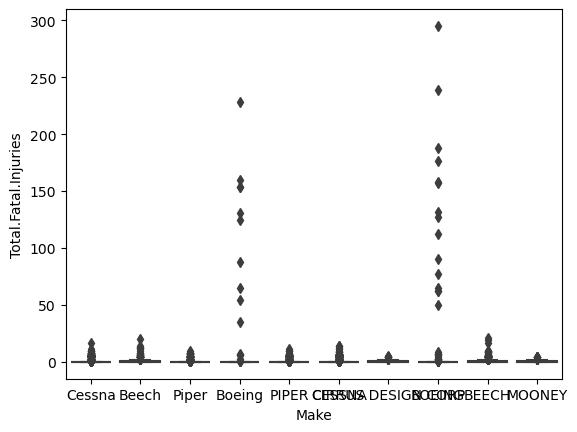

In [15]:
top_makes = airplane_df['Make'].value_counts().head(10).index
top_makes_df = airplane_df[airplane_df['Make'].isin(top_makes)]

sns.boxplot(x = 'Make', y = 'Total.Fatal.Injuries', data = top_makes_df)
plt.show()

## Make Cleaning 

In [16]:
airplane_df["Make"].value_counts()

Make
CESSNA             4867
Cessna             3608
PIPER              2805
Piper              1910
BOEING             1037
                   ... 
GLINES                1
RAMMEL THOMAS W       1
HEMMER                1
W.H. Hunnicutt        1
ORLICAN S R O         1
Name: count, Length: 3874, dtype: int64

In [17]:
airplane_df["Make"] = airplane_df["Make"].str.upper()

In [18]:
# Cessna
airplane_df["Make"] = airplane_df["Make"].replace(to_replace=["CESSNA AIRCRAFT CO", "CESSNA AIRCRAFT COMPANY", "CESSNA AIRCRAFT", "CESSNA ECTOR", "CESSNA SKYHAWK II", "CESSNA AIRCRAFT CO"], value="CESSNA")

In [19]:
# Piper
airplane_df["Make"] = airplane_df["Make"].replace(to_replace=["PIPER AIRCRAFT INC", "PIPER AIRCRAFT CORPORATION", "PIPER AIRCRAFT", "NEW PIPER AIRCRAFT INC", "'PIPER AIRCRAFT, INC.'", "NEW PIPER", "PIPER AEROSTAR", "PIPER-AEROSTAR", "PIPER PAWNEE", "JETPROP DLX PIPER"], value="PIPER")

In [20]:
# The Beechcraft and Hawker companies merged, it is now called Beechcraft
airplane_df["Make"] = airplane_df["Make"].replace(to_replace=["BEECHCRAFT", "HAWKER BEECHCRAFT", "HAWKER BEECHCRAFT CORP", "HAWKER BEECHCRAFT CORPORATION", "HAWKER BEECHCRAFT CORP.", "BEECH AIRCRAFT CORPORATION", "BEECH AIRCRAFT", "HAWKER BEECH", "HAWKER-BEECHCRAFT", "BEECH AIRCRAFT CO.", "BEECH AIRCRAFT CORP", "BEECHCRAFT CORPORATION", "HAWKER-BEECHCRAFT CORPORATION", "HAWKER", "HAWKER SIDDELEY", "HAWKER AIRCRAFT LTD"], value="BEECH")

In [21]:
# Stearman merged into Boeing
airplane_df["Make"] = airplane_df["Make"].replace(to_replace=["THE BOEING COMPANY", "BOEING COMPANY", "BOEING STEARMAN", "'BOEING COMPANY, LONG BEACH DIV'", "BOEING-STEARMAN", "BOEING 777-306ER", "BOEING (STEARMAN)", "BOEING COMMERCIAL AIRPLANE GRO", "BOEING OF CANADA/DEHAV DIV", "STEARMAN", "STEARMAN AIRCRAFT"], value="BOEING")

In [22]:
# Mooney
airplane_df["Make"] = airplane_df["Make"].replace(to_replace=["MOONEY AIRCRAFT CORP.", "MOONEY AIRPLANE CO INC", "MOONEY INTERNATIONAL CORP", "MOONEY AIRCRAFT CORPORATION", "MOONEY AIRCRAFT CORP", "'MOONEY AIRPLANE COMPANY, INC.'"], value="MOONEY")

In [23]:
# Grumann and Northrop merged
airplane_df["Make"] = airplane_df["Make"].replace(to_replace=["GRUMMAN ACFT ENG COR-SCHWEIZER", "GRUMMAN AMERICAN AVN. CORP", "GRUMMAN AMERICAN", "GRUMMAN-SCHWEIZER", "GRUMMAN AIRCRAFT ENG CORP", "GRUMMAN ACFT ENG", "GRUMMAN AMERICAN AVIATION", "GRUMMAN SCHWEIZER", "GRUMMAN AIRCRAFT COR-SCHWEIZER", "GRUMMAN AMERICAN AVN. CORP", "GRUMMAN AMERICAN CORPORATION", "GRUMMAN AIRCRAFT", "GRUMMAN ACFT ENG COR", "GRUMMAN AMERICAN AVIATION CORP", "NORTHROP"], value="GRUMMAN")

In [24]:
# Airbus
airplane_df["Make"] = airplane_df["Make"].replace(to_replace=["AIRBUS INDUSTRIE"], value="AIRBUS")

In [25]:
# Maule
airplane_df["Make"] = airplane_df["Make"].replace(to_replace=["MAULE AIRCRAFT CORP"], value="MAULE")

In [26]:
# Aeronca
airplane_df["Make"] = airplane_df["Make"].replace(to_replace=["AERONCA AIRCRAFT CORPORATION", "AERONCA CHAMPION", "AERONCA CHAMP"], value="AERONCA")

In [19]:
# Top 10
airplane_df["Make"].value_counts().head(10)

Make
CESSNA      8525
PIPER       4772
BEECH       1785
BOEING      1371
MOONEY       466
GRUMMAN      381
AIRBUS       288
BELLANCA     282
MAULE        233
AERONCA      232
Name: count, dtype: int64

In [20]:
# Remove any Make that have a value count under 232
airplane_df.groupby("Make").filter(lambda x : len(x)>=232)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,NaN,NaN,NaN,BLACKBURN AG STRIP,...,Personal,NaN,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,NaN,NaN,N58,HANOVER,...,Business,NaN,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982
12,20020917X02148,Accident,FTW82FRJ07,1982-01-02,"HOMER, LA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,0.0,0.0,1.0,0.0,IMC,Cruise,Probable Cause,02-01-1983
13,20020917X02134,Accident,FTW82FRA14,1982-01-02,"HEARNE, TX",United States,NaN,NaN,T72,HEARNE MUNICIPAL,...,Personal,NaN,1.0,0.0,0.0,0.0,IMC,Takeoff,Probable Cause,02-01-1983
15,20020917X02117,Accident,FTW82FPG08,1982-01-02,"LITTLE ROCK, AR",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,02-01-1983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88858,20221211106438,Accident,ERA23LA083,2022-12-09,"Hawkinsville, GA",United States,321814N,0832534W,51A,HAWKINSVILLE-PULASKI COUNTY,...,Personal,NaN,0.0,1.0,0.0,0.0,VMC,NaN,NaN,15-12-2022
88861,20221215106460,Accident,ERA23LA088,2022-12-10,"Alabaster, AL",United States,331040N,0086470W,EET,NaN,...,Personal,NaN,0.0,0.0,0.0,2.0,NaN,NaN,NaN,19-12-2022
88865,20221212106444,Accident,ERA23LA085,2022-12-12,"Knoxville, TN",United States,355745N,0835218W,DKX,KNOXVILLE DOWNTOWN ISLAND,...,Instructional,Knoxville Flight Training Academy,0.0,0.0,0.0,1.0,VMC,NaN,NaN,15-12-2022
88869,20221213106455,Accident,WPR23LA065,2022-12-13,"Lewistown, MT",United States,047257N,0109280W,KLWT,Lewiston Municipal Airport,...,NaN,NaN,0.0,0.0,0.0,1.0,NaN,NaN,NaN,14-12-2022


## Event Date Filtering 

In [27]:
# Filtering out dates before January 01, 1998
airplane_df["Event.Date"] = pd.to_datetime(df["Event.Date"])
airplane_df[airplane_df["Event.Date"] > "1998-01-01"]

,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,...,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,State
Event.Id,,,,,,,,,,,,,,,,,,,,,


In [40]:
airplane_df.to_csv('airplane_df')

[nan, 'N58', 'T72', '5G6', 'YIP', '49G', 'VNY', 'SOP', 'HPN', 'E92', 'STX', 'L39', '0A6', 'Q35', 'BET', 'K07', '1C1', '2W2', 'LRD', 'X41', 'PHO', 'PUW', '3MY', 'SKY', 'SC42', 'DWH', 'SBS', 'P06', 'PWK', '28V', 'AVO', 'ORD', 'CKB', '11', 'HOB', 'SFF', 'JFK', 'ANE', '1B7', '005', 'MHV', 'T05', 'PCU', 'MRI', 'HSV', 'KS30', 'SWO', 'RKP', 'IAD', '2G9', 'Y76', 'IGM', 'SMO', 'SHV', 'GRR', 'MIA', 'AK61', 'SJC', 'ORL', 'MDD', 'X64', 'E51', 'MSL', 'KEB', '39D', 'Q38', 'SDF', '004', 'TOP', 'O4TX', 'T17', 'TAN', 'FLG', 'AHN', 'Z38', 'K84', 'O20', 'BJC', 'CHO', 'OR35', '11CA', 'LOU', 'TRK', 'AVX', '027', 'O85', 'L35', 'M74', '10', 'LKP', 'CDW', 'DED', 'TKI', 'TAD', 'GON', 'X31', 'SVA', 'VGT', 'LCR', 'AID', 'SWF', '6R6', 'U42', 'HDN', 'PHL', 'N44', 'BNO', '04A', 'MFR', 'RHV', 'SGF', '2D8', 'I01', '8Y2', '3S2', 'S40', 'CGI', 'C61', 'ATS', 'BEH', '4I7', 'MTO', 'VPZ', '15R', 'CRQ', 'Y25', 'PHF', 'PYM', 'FLL', '22G', '3GV', 'MBY', '82J', 'IVO', 'GR3', '6I4', 'DTG', '5G9', '3J1', 'ONT', 'DSM', 'C56', 'FW